In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
wvl = 642         # wavelength [nm]
NA = 1.4          # numerical aperture 
n = 1.0          # refractive index of propagating medium
pixel_size = 2*6.45  # effective camera pixel size [nm]
chip_size = 256     # pixels

def widefield_psf_2d(wvl, NA, n, pixel_size, chip_size, z=0.0):
    """
    Construct the electric field for a widefield PSF in 2d.
    
    Parameters
    ----------
    wvl : float
        Wavelength of emitted light in nm.
    NA : float
        Numerical aperture of the optical system
    n : float
        Refractive index surrounding point source
    pixel_size : float
        Effective pixel size of camera chip in nm
    chip_size : int
        How many pixels on the camera chip?
    z : float
        Depth from focus
        
    Returns
    -------
    psf : np.array 
        Array of np.complex values describing electric field of the PSF.
    """
    # Create frequency space
    # f = np.arange(-chip_size//2,chip_size//2)/(pixel_size*chip_size) # <cycles per chip>*<cycle size [nm^-1]>
    # If f above is used, we need an additional ifftshift
    f = np.fft.fftfreq(chip_size, pixel_size)*wvl/n
    X, Y = np.meshgrid(f,f)

    # Create an aperture in frequency space
    # Clip on 1/<spatial resolution of the system> (spatial frequency)
    # Note the "missing" factor of 2 since we are thresholding on radius
    # rescale by refractive index
    aperture = (X*X+Y*Y) < (NA/n)**2

    # The pupil can also contain aberrations, but they must
    # be clipped by aperture 
    k = 2.0*np.pi/(n*wvl)
    pf = np.exp(1j*k*z*np.sqrt(1-np.minimum(X*X+Y*Y,1)))
    pupil = aperture*pf

    # Take the inverse fourier transform of the pupil
    # to get the point spread function
    psf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(pupil)))
    
    return psf

def amplitude_psf(psf):
    """ Return the amplitude of a PSF, described by its electric field. """
    return np.abs(psf)

def intensity_psf(psf):
    """ Return the intensity of a PSF, described by its electric field. """
    return np.abs(psf*np.conj(psf))

# psf = widefield_psf_2d(wvl, NA, n, pixel_size, chip_size)
res_z = 2*wvl/(NA*NA)
psf_z = np.array([widefield_psf_2d(wvl, NA, n, pixel_size, chip_size,z=i) for i in np.linspace(-res_z,res_z,chip_size)])

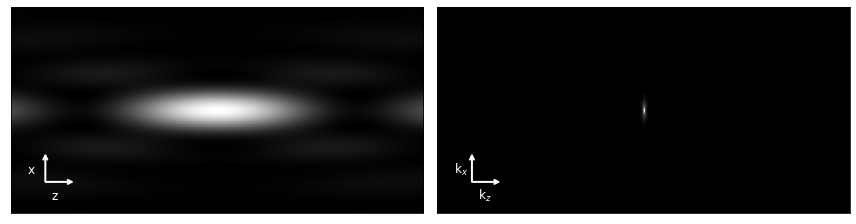

In [3]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(intensity_psf(psf_z[:,psf_z.shape[1]//2,chip_size//4:-chip_size//4]).T, cmap='gray')
axs[0].annotate("", xy=(40, chip_size//2-20), xytext=(20, chip_size//2-20),
            arrowprops=dict(arrowstyle="->",color='white',linewidth=2),
            color='white')
axs[0].annotate("", xy=(21, chip_size//2-39), xytext=(21, chip_size//2-19),
            arrowprops=dict(arrowstyle="->",color='white',linewidth=2),
            color='white')
axs[0].annotate("z", xy=(25, chip_size//2-9),color="white",fontsize=12)
axs[0].annotate("x", xy=(10, chip_size//2-25),color="white",fontsize=12)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(intensity_psf(np.fft.ifftshift(np.fft.fft2(intensity_psf(psf_z[:,psf_z.shape[1]//2,:]))))[:,chip_size//4:-chip_size//4].T,cmap='gray')
axs[1].annotate("", xy=(40, chip_size//2-20), xytext=(20, chip_size//2-20),
            arrowprops=dict(arrowstyle="->",color='white',linewidth=2),
            color='white')
axs[1].annotate("", xy=(21, chip_size//2-39), xytext=(21, chip_size//2-19),
            arrowprops=dict(arrowstyle="->",color='white',linewidth=2),
            color='white')
axs[1].annotate("k$_z$", xy=(25, chip_size//2-9),color="white",fontsize=12)
axs[1].annotate("k$_x$", xy=(10, chip_size//2-25),color="white",fontsize=12)
axs[1].set_xticks([])
axs[1].set_yticks([])
fig.tight_layout()